In [15]:
%load_ext autoreload
%autoreload 2

import os
import time

import numpy as np

from matplotlib import pyplot as plt

import torch
import torch.nn as nn
import torchvision
from torchvision.datasets.vision import VisionDataset
from torch.utils.data import DataLoader
from torchvision import transforms


from datasets import BadNetsDataset, WaNetDataset, SIGDataset
from simclr import SimClrBackbone

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [16]:
device = "cuda"
epochs = 300
batch_size = 128

In [17]:
LOAD_CHECKPOINT = False
CHECKPOINT_NAME = "SIG-60-SimCLR-140.pt"

DATASET = "sig40"

if DATASET == "badnets":
    TARGET_CLASS = 1
elif DATASET == "wanet":
    TARGET_CLASS = 0
elif DATASET == "sig":
    TARGET_CLASS = 0
elif DATASET == "sig40":
    TARGET_CLASS = 0
else:
    raise Exception("Invalid dataset")

## Poison dataset

In [18]:
dataset = torchvision.datasets.CIFAR10(root='C:/Datasets', train=True, download=True)

if DATASET == "badnets":
    poison_dataset = BadNetsDataset(dataset, TARGET_CLASS, "triggers/trigger_10.png", seed=1)
elif DATASET == "wanet":
    poison_dataset = WaNetDataset(dataset, TARGET_CLASS, seed=1)
elif DATASET == "sig":
    poison_dataset = SIGDataset(dataset, TARGET_CLASS, 20, 6, seed=1)
elif DATASET == "sig40":
    poison_dataset = SIGDataset(dataset, TARGET_CLASS, 20, 6, alpha=0.4, seed=2)
else:
    raise Exception("Invalid dataset")

classes = ('plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

Files already downloaded and verified


## SimCLR data augmentations

In [19]:
class ConstrastiveDataset(VisionDataset):

    def __init__(self, original_dataset: VisionDataset, s: int = 0.5):
        self.original_dataset = original_dataset

        self.transforms = transforms.Compose([
            transforms.RandomHorizontalFlip(0.5),
            transforms.RandomResizedCrop(32,(0.8,1.0),antialias=False),
            transforms.Compose([transforms.RandomApply([
                transforms.ColorJitter(0.8*s, 0.8*s, 0.8*s, 0.2*s)], p = 0.8),
                transforms.RandomGrayscale(p=0.2)]),
            transforms.Normalize((0.4914, 0.4822, 0.4465), (0.247, 0.243, 0.261))
            ])
    
    def __len__(self):
        return len(self.original_dataset)
    
    def __getitem__(self, index):
        img = self.original_dataset[index][0]
        augmented_img_1 = self.transforms(img)
        augmented_img_2 = self.transforms(img)
        return augmented_img_1, augmented_img_2
    
constrastive_dataset = ConstrastiveDataset(poison_dataset)

## SimCLR model

In [20]:
model = SimClrBackbone()
model = model.to(device)

c:\Users\Luka\AppData\Local\Programs\Python\Python311\Lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\Luka\AppData\Local\Programs\Python\Python311\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


## LARS optimizer

In [21]:
from torch.optim.optimizer import Optimizer, required
import re

EETA_DEFAULT = 0.001


class LARS(Optimizer):
    """
    Layer-wise Adaptive Rate Scaling for large batch training.
    Introduced by "Large Batch Training of Convolutional Networks" by Y. You,
    I. Gitman, and B. Ginsburg. (https://arxiv.org/abs/1708.03888)
    """

    def __init__(
        self,
        params,
        lr=required,
        momentum=0.9,
        use_nesterov=False,
        weight_decay=0.0,
        exclude_from_weight_decay=None,
        exclude_from_layer_adaptation=None,
        classic_momentum=True,
        eeta=EETA_DEFAULT,
    ):
        """Constructs a LARSOptimizer.
        Args:
        lr: A `float` for learning rate.
        momentum: A `float` for momentum.
        use_nesterov: A 'Boolean' for whether to use nesterov momentum.
        weight_decay: A `float` for weight decay.
        exclude_from_weight_decay: A list of `string` for variable screening, if
            any of the string appears in a variable's name, the variable will be
            excluded for computing weight decay. For example, one could specify
            the list like ['batch_normalization', 'bias'] to exclude BN and bias
            from weight decay.
        exclude_from_layer_adaptation: Similar to exclude_from_weight_decay, but
            for layer adaptation. If it is None, it will be defaulted the same as
            exclude_from_weight_decay.
        classic_momentum: A `boolean` for whether to use classic (or popular)
            momentum. The learning rate is applied during momeuntum update in
            classic momentum, but after momentum for popular momentum.
        eeta: A `float` for scaling of learning rate when computing trust ratio.
        name: The name for the scope.
        """

        self.epoch = 0
        defaults = dict(
            lr=lr,
            momentum=momentum,
            use_nesterov=use_nesterov,
            weight_decay=weight_decay,
            exclude_from_weight_decay=exclude_from_weight_decay,
            exclude_from_layer_adaptation=exclude_from_layer_adaptation,
            classic_momentum=classic_momentum,
            eeta=eeta,
        )

        super(LARS, self).__init__(params, defaults)
        self.lr = lr
        self.momentum = momentum
        self.weight_decay = weight_decay
        self.use_nesterov = use_nesterov
        self.classic_momentum = classic_momentum
        self.eeta = eeta
        self.exclude_from_weight_decay = exclude_from_weight_decay
        # exclude_from_layer_adaptation is set to exclude_from_weight_decay if the
        # arg is None.
        if exclude_from_layer_adaptation:
            self.exclude_from_layer_adaptation = exclude_from_layer_adaptation
        else:
            self.exclude_from_layer_adaptation = exclude_from_weight_decay

    def step(self, epoch=None, closure=None):
        loss = None
        if closure is not None:
            loss = closure()

        if epoch is None:
            epoch = self.epoch
            self.epoch += 1

        for group in self.param_groups:
            weight_decay = group["weight_decay"]
            momentum = group["momentum"]
            eeta = group["eeta"]
            lr = group["lr"]

            for p in group["params"]:
                if p.grad is None:
                    continue

                param = p.data
                grad = p.grad.data

                param_state = self.state[p]

                # TODO: get param names
                # if self._use_weight_decay(param_name):
                grad += self.weight_decay * param

                if self.classic_momentum:
                    trust_ratio = 1.0

                    # TODO: get param names
                    # if self._do_layer_adaptation(param_name):
                    w_norm = torch.norm(param)
                    g_norm = torch.norm(grad)

                    device = g_norm.get_device()
                    trust_ratio = torch.where(
                        w_norm.gt(0),
                        torch.where(
                            g_norm.gt(0),
                            (self.eeta * w_norm / g_norm),
                            torch.Tensor([1.0]).to(device),
                        ),
                        torch.Tensor([1.0]).to(device),
                    ).item()

                    scaled_lr = lr * trust_ratio
                    if "momentum_buffer" not in param_state:
                        next_v = param_state["momentum_buffer"] = torch.zeros_like(
                            p.data
                        )
                    else:
                        next_v = param_state["momentum_buffer"]

                    next_v.mul_(momentum).add_(scaled_lr, grad)
                    if self.use_nesterov:
                        update = (self.momentum * next_v) + (scaled_lr * grad)
                    else:
                        update = next_v

                    p.data.add_(-update)
                else:
                    raise NotImplementedError

        return loss

    def _use_weight_decay(self, param_name):
        """Whether to use L2 weight decay for `param_name`."""
        if not self.weight_decay:
            return False
        if self.exclude_from_weight_decay:
            for r in self.exclude_from_weight_decay:
                if re.search(r, param_name) is not None:
                    return False
        return True

    def _do_layer_adaptation(self, param_name):
        """Whether to do layer-wise learning rate adaptation for `param_name`."""
        if self.exclude_from_layer_adaptation:
            for r in self.exclude_from_layer_adaptation:
                if re.search(r, param_name) is not None:
                    return False
        return True

## SimCLR contrastive loss

In [22]:
class SimCLR_Loss(nn.Module):
    def __init__(self, temperature):
        super(SimCLR_Loss, self).__init__()
        self.temperature = temperature

        self.criterion = nn.CrossEntropyLoss(reduction="sum")
        self.similarity_f = nn.CosineSimilarity(dim=2)

    def mask_correlated_samples(self, batch_size):
        N = 2 * batch_size
        mask = torch.ones((N, N), dtype=bool)
        mask = mask.fill_diagonal_(0)
        
        for i in range(batch_size):
            mask[i, batch_size + i] = 0
            mask[batch_size + i, i] = 0
            
        return mask

    def forward(self, z_i, z_j):
        """
        We do not sample negative examples explicitly.
        Instead, given a positive pair, similar to (Chen et al., 2017), we treat the other 2(N − 1) augmented examples within a minibatch as negative examples.
        """
        batch_size = z_i.shape[0]
        mask = self.mask_correlated_samples(batch_size)

        N = 2 * batch_size #* self.world_size
        
        #z_i_ = z_i / torch.sqrt(torch.sum(torch.square(z_i),dim = 1, keepdim = True))
        #z_j_ = z_j / torch.sqrt(torch.sum(torch.square(z_j),dim = 1, keepdim = True))

        z = torch.cat((z_i, z_j), dim=0)

        sim = self.similarity_f(z.unsqueeze(1), z.unsqueeze(0)) / self.temperature
        
        #print(sim.shape)

        sim_i_j = torch.diag(sim, batch_size)
        sim_j_i = torch.diag(sim, batch_size)
        
        
        # We have 2N samples, but with Distributed training every GPU gets N examples too, resulting in: 2xNxN
        positive_samples = torch.cat((sim_i_j, sim_j_i), dim=0).reshape(N, 1)
        negative_samples = sim[mask].reshape(N, -1)
        
        
        #SIMCLR
        labels = torch.from_numpy(np.array([0]*N)).reshape(-1).to(positive_samples.device).long() #.float()
        #labels was torch.zeros(N)
        logits = torch.cat((positive_samples, negative_samples), dim=1)
        loss = self.criterion(logits, labels)
        loss /= N
        
        return loss

## Training

In [23]:
optimizer = LARS(
    [params for params in model.parameters() if params.requires_grad],
    lr=0.2,
    weight_decay=1e-6,
    exclude_from_weight_decay=["batch_normalization", "bias"],
)

# "decay the learning rate with the cosine decay schedule without restarts"
warmupscheduler = torch.optim.lr_scheduler.LambdaLR(optimizer, lambda epoch : (epoch+1)/10.0, verbose = False)
mainscheduler = torch.optim.lr_scheduler.CosineAnnealingWarmRestarts(optimizer, 500, eta_min=0.05, last_epoch=-1, verbose = False)

criterion = SimCLR_Loss(temperature=0.5)

dataloader = DataLoader(constrastive_dataset, batch_size=batch_size, shuffle=True, num_workers=0)
dataloader_no_contrastive = DataLoader(poison_dataset, batch_size=batch_size, shuffle=True, num_workers=0)

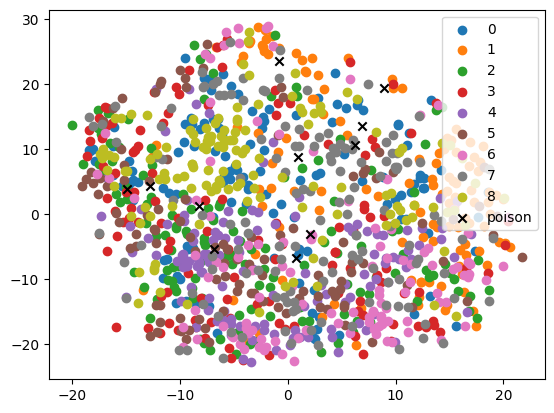

In [24]:
from sklearn.manifold import TSNE

def plot_features(model: nn.Module, dataloader: DataLoader, batches: int = None):
    model.eval()

    features = None
    labels_poison = None
    labels_true = None

    for i, (img, labels_batch_poison, labels_batch_true) in enumerate(dataloader):

        if batches is not None and i>=batches:
            break
    
        with torch.no_grad():
            features_batch = model(img.to(device)).cpu().data.numpy()
            
        if features is None:
            features = features_batch
            labels_poison = labels_batch_poison
            labels_true = labels_batch_true
        else:
            features = np.append(features, features_batch, axis=0)
            labels_poison = np.append(labels_poison, labels_batch_poison, axis=0)
            labels_true = np.append(labels_true, labels_batch_true, axis=0)
    
    tsne = TSNE(n_components = 2, perplexity = 50)
    tsne_features = tsne.fit_transform(features)
    num_classes = max(labels_batch_poison)

    labels = labels_true[:]
    labels[[poison_dataset.is_poison(i) for i in range(len(labels))]] = 10

    for i in range(num_classes):
        plt.scatter(tsne_features[labels==i,1], tsne_features[labels==i,0])
    plt.scatter(tsne_features[labels==10,1], tsne_features[labels==10,0], c = "black", marker= "x")

    plt.legend([str(i) for i in range(num_classes)] + ["poison"])
    plt.show()

    model.train()

plot_features(model, dataloader_no_contrastive, 10)

In [25]:
def train(dataloader, model, criterion, optimizer):
    loss_epoch = 0
    
    for step, (x_i, x_j) in enumerate(dataloader):
        optimizer.zero_grad()
        x_i = x_i.to(device).float()
        x_j = x_j.to(device).float()

        # positive pair, with encoding
        z_i = model(x_i)
        z_j = model(x_j)

        loss = criterion(z_i, z_j)
        loss.backward()

        optimizer.step()
        
        if step % 50 == 0:
            print(f"\tStep [{step}/{len(dataloader)}]\t Loss: {round(loss.item(), 5)}")

        loss_epoch += loss.item()
    return loss_epoch / len(dataloader)

In [26]:
def save_model(model, optimizer, scheduler, epoch, name):
    out = os.path.join('./saved_models/', name)

    torch.save({'model_state_dict': model.state_dict(),
                'optimizer_state_dict': optimizer.state_dict(),
                'scheduler_state_dict': scheduler.state_dict(),
                'epoch': epoch
                }, out)

    print(f"\tSaved model, optimizer, scheduler and epoch info to {out}")

In [27]:
start_epoch = 0

load_checkpoint = False
checkpoint_name = "WaNet-SimCLR_150.pt"

if LOAD_CHECKPOINT:
    out = os.path.join('./saved_models/', CHECKPOINT_NAME)
    checkpoint = torch.load(out, map_location=device)
    model.load_state_dict(checkpoint["model_state_dict"])
    optimizer.load_state_dict(checkpoint["optimizer_state_dict"])
    mainscheduler.load_state_dict(checkpoint["scheduler_state_dict"])
    start_epoch = checkpoint["epoch"] + 1

Epoch [141/300]	
	Step [0/391]	 Loss: 3.59722
	Step [50/391]	 Loss: 3.60097
	Step [100/391]	 Loss: 3.59643
	Step [150/391]	 Loss: 3.60639
	Step [200/391]	 Loss: 3.59634
	Step [250/391]	 Loss: 3.59867
	Step [300/391]	 Loss: 3.60246
	Step [350/391]	 Loss: 3.59805

	Training Loss: 3.598562582679417
	Time Taken: 3.682253396511078 minutes
Epoch [142/300]	
	Step [0/391]	 Loss: 3.59728
	Step [50/391]	 Loss: 3.59298
	Step [100/391]	 Loss: 3.60205
	Step [150/391]	 Loss: 3.5964
	Step [200/391]	 Loss: 3.59983
	Step [250/391]	 Loss: 3.59768
	Step [300/391]	 Loss: 3.60283
	Step [350/391]	 Loss: 3.59716

	Training Loss: 3.5985980363148253
	Time Taken: 3.6955777684847515 minutes
Epoch [143/300]	
	Step [0/391]	 Loss: 3.59667
	Step [50/391]	 Loss: 3.59723
	Step [100/391]	 Loss: 3.60138
	Step [150/391]	 Loss: 3.60189
	Step [200/391]	 Loss: 3.59989
	Step [250/391]	 Loss: 3.60177
	Step [300/391]	 Loss: 3.59935
	Step [350/391]	 Loss: 3.59564

	Training Loss: 3.5981977760334454
	Time Taken: 3.65725781122843

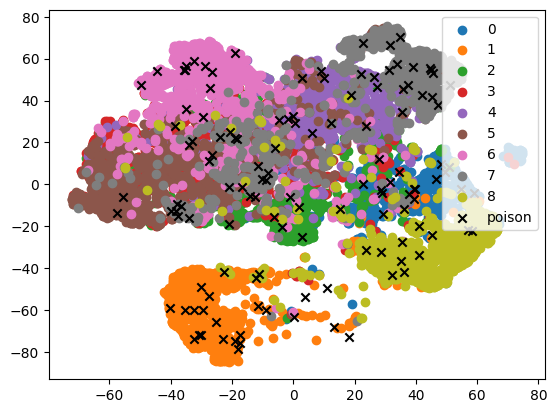

Epoch [151/300]	
	Step [0/391]	 Loss: 3.60052
	Step [50/391]	 Loss: 3.59967
	Step [100/391]	 Loss: 3.59988
	Step [150/391]	 Loss: 3.59386
	Step [200/391]	 Loss: 3.59876
	Step [250/391]	 Loss: 3.59501
	Step [300/391]	 Loss: 3.59466
	Step [350/391]	 Loss: 3.5965

	Training Loss: 3.59737640329639
	Time Taken: 3.6476301312446595 minutes
Epoch [152/300]	
	Step [0/391]	 Loss: 3.60261
	Step [50/391]	 Loss: 3.59559
	Step [100/391]	 Loss: 3.59567
	Step [150/391]	 Loss: 3.59645
	Step [200/391]	 Loss: 3.59454
	Step [250/391]	 Loss: 3.5997
	Step [300/391]	 Loss: 3.59295
	Step [350/391]	 Loss: 3.59345

	Training Loss: 3.5970124448351846
	Time Taken: 3.6468642354011536 minutes
Epoch [153/300]	
	Step [0/391]	 Loss: 3.592
	Step [50/391]	 Loss: 3.60001
	Step [100/391]	 Loss: 3.59393
	Step [150/391]	 Loss: 3.59835
	Step [200/391]	 Loss: 3.59681
	Step [250/391]	 Loss: 3.59426
	Step [300/391]	 Loss: 3.59761
	Step [350/391]	 Loss: 3.59907

	Training Loss: 3.5969353136808975
	Time Taken: 3.6555400490760803 

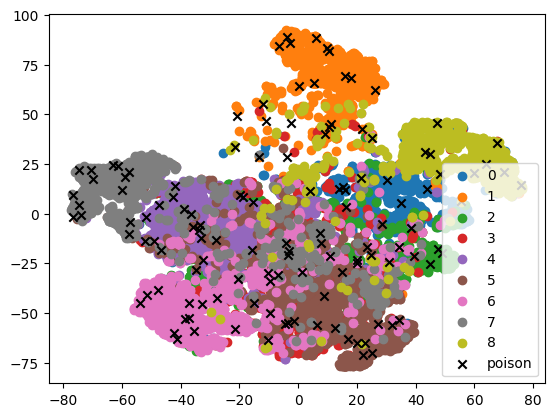

Epoch [161/300]	
	Step [0/391]	 Loss: 3.59823
	Step [50/391]	 Loss: 3.59655
	Step [100/391]	 Loss: 3.59815
	Step [150/391]	 Loss: 3.59761
	Step [200/391]	 Loss: 3.60025
	Step [250/391]	 Loss: 3.59252
	Step [300/391]	 Loss: 3.59722
	Step [350/391]	 Loss: 3.59797

	Training Loss: 3.5963999987258326
	Time Taken: 3.6478948553403217 minutes
Epoch [162/300]	
	Step [0/391]	 Loss: 3.59413
	Step [50/391]	 Loss: 3.5905
	Step [100/391]	 Loss: 3.59903
	Step [150/391]	 Loss: 3.60081
	Step [200/391]	 Loss: 3.59786
	Step [250/391]	 Loss: 3.59522
	Step [300/391]	 Loss: 3.59868
	Step [350/391]	 Loss: 3.60922

	Training Loss: 3.5959164236512637
	Time Taken: 3.661008616288503 minutes
Epoch [163/300]	
	Step [0/391]	 Loss: 3.59685
	Step [50/391]	 Loss: 3.59726
	Step [100/391]	 Loss: 3.59981
	Step [150/391]	 Loss: 3.59872
	Step [200/391]	 Loss: 3.59406
	Step [250/391]	 Loss: 3.59818
	Step [300/391]	 Loss: 3.59589
	Step [350/391]	 Loss: 3.59873

	Training Loss: 3.5962962226184736
	Time Taken: 3.6450256109237

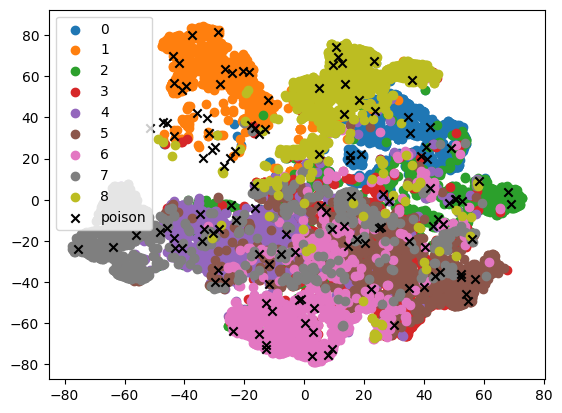

Epoch [171/300]	
	Step [0/391]	 Loss: 3.59391
	Step [50/391]	 Loss: 3.59221
	Step [100/391]	 Loss: 3.59646
	Step [150/391]	 Loss: 3.59644
	Step [200/391]	 Loss: 3.60065
	Step [250/391]	 Loss: 3.59346
	Step [300/391]	 Loss: 3.59808
	Step [350/391]	 Loss: 3.59633

	Training Loss: 3.5951358467111807
	Time Taken: 3.6661662379900615 minutes
Epoch [172/300]	
	Step [0/391]	 Loss: 3.59272
	Step [50/391]	 Loss: 3.59038
	Step [100/391]	 Loss: 3.59467
	Step [150/391]	 Loss: 3.59515
	Step [200/391]	 Loss: 3.5945
	Step [250/391]	 Loss: 3.59525
	Step [300/391]	 Loss: 3.59789
	Step [350/391]	 Loss: 3.59349

	Training Loss: 3.5948022832650968
	Time Taken: 3.615616758664449 minutes
Epoch [173/300]	
	Step [0/391]	 Loss: 3.59411
	Step [50/391]	 Loss: 3.59685
	Step [100/391]	 Loss: 3.59752
	Step [150/391]	 Loss: 3.5979
	Step [200/391]	 Loss: 3.60093
	Step [250/391]	 Loss: 3.59457
	Step [300/391]	 Loss: 3.59355
	Step [350/391]	 Loss: 3.59799

	Training Loss: 3.5950152489840224
	Time Taken: 3.64293364683787

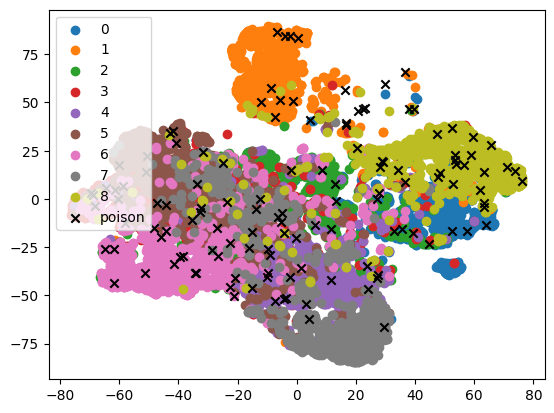

Epoch [181/300]	
	Step [0/391]	 Loss: 3.59776
	Step [50/391]	 Loss: 3.59132
	Step [100/391]	 Loss: 3.59814
	Step [150/391]	 Loss: 3.59921
	Step [200/391]	 Loss: 3.59324
	Step [250/391]	 Loss: 3.59595
	Step [300/391]	 Loss: 3.60065
	Step [350/391]	 Loss: 3.5976

	Training Loss: 3.593844735104105
	Time Taken: 3.665802764892578 minutes
Epoch [182/300]	
	Step [0/391]	 Loss: 3.59418
	Step [50/391]	 Loss: 3.5898
	Step [100/391]	 Loss: 3.59956
	Step [150/391]	 Loss: 3.59615
	Step [200/391]	 Loss: 3.59388
	Step [250/391]	 Loss: 3.59087
	Step [300/391]	 Loss: 3.59367
	Step [350/391]	 Loss: 3.5924

	Training Loss: 3.5939847233960087
	Time Taken: 3.667769940694173 minutes
Epoch [183/300]	
	Step [0/391]	 Loss: 3.59719
	Step [50/391]	 Loss: 3.58874
	Step [100/391]	 Loss: 3.59388
	Step [150/391]	 Loss: 3.58819
	Step [200/391]	 Loss: 3.59865
	Step [250/391]	 Loss: 3.59694
	Step [300/391]	 Loss: 3.59164
	Step [350/391]	 Loss: 3.60251

	Training Loss: 3.593714185383009
	Time Taken: 3.664786609013875 mi

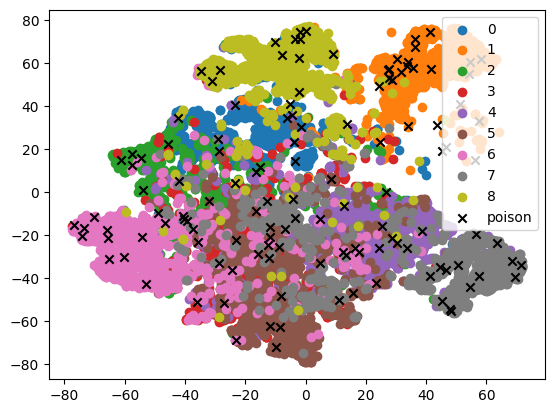

Epoch [191/300]	
	Step [0/391]	 Loss: 3.59097
	Step [50/391]	 Loss: 3.59734
	Step [100/391]	 Loss: 3.59397
	Step [150/391]	 Loss: 3.59058
	Step [200/391]	 Loss: 3.59692
	Step [250/391]	 Loss: 3.59247
	Step [300/391]	 Loss: 3.59354
	Step [350/391]	 Loss: 3.59634

	Training Loss: 3.593166134241597
	Time Taken: 3.681670852502187 minutes
Epoch [192/300]	
	Step [0/391]	 Loss: 3.59059
	Step [50/391]	 Loss: 3.59739
	Step [100/391]	 Loss: 3.59294
	Step [150/391]	 Loss: 3.59322
	Step [200/391]	 Loss: 3.59559
	Step [250/391]	 Loss: 3.58793
	Step [300/391]	 Loss: 3.59093
	Step [350/391]	 Loss: 3.59251

	Training Loss: 3.593072980870981
	Time Taken: 3.6754876573880515 minutes
Epoch [193/300]	
	Step [0/391]	 Loss: 3.59354
	Step [50/391]	 Loss: 3.59066
	Step [100/391]	 Loss: 3.58938
	Step [150/391]	 Loss: 3.59156
	Step [200/391]	 Loss: 3.59629
	Step [250/391]	 Loss: 3.59421
	Step [300/391]	 Loss: 3.59202
	Step [350/391]	 Loss: 3.59582

	Training Loss: 3.5926449268370333
	Time Taken: 3.66700433890024

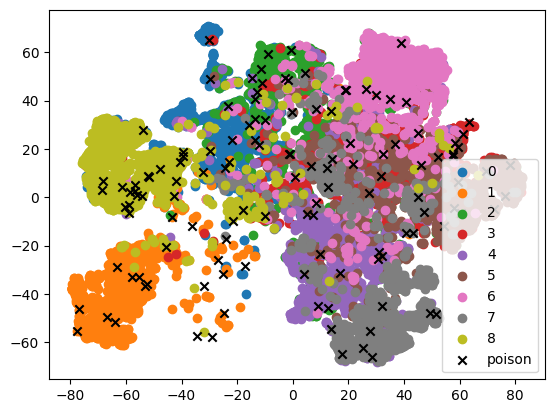

Epoch [201/300]	
	Step [0/391]	 Loss: 3.5915
	Step [50/391]	 Loss: 3.59321
	Step [100/391]	 Loss: 3.59613
	Step [150/391]	 Loss: 3.59287
	Step [200/391]	 Loss: 3.59538
	Step [250/391]	 Loss: 3.59391
	Step [300/391]	 Loss: 3.58969
	Step [350/391]	 Loss: 3.59399

	Training Loss: 3.592098093398697
	Time Taken: 3.764638050397237 minutes
Epoch [202/300]	
	Step [0/391]	 Loss: 3.59389
	Step [50/391]	 Loss: 3.58962
	Step [100/391]	 Loss: 3.601
	Step [150/391]	 Loss: 3.59092
	Step [200/391]	 Loss: 3.59456
	Step [250/391]	 Loss: 3.59029
	Step [300/391]	 Loss: 3.59076
	Step [350/391]	 Loss: 3.6011

	Training Loss: 3.591780280213222
	Time Taken: 3.7606547554334004 minutes
Epoch [203/300]	
	Step [0/391]	 Loss: 3.59206
	Step [50/391]	 Loss: 3.59624
	Step [100/391]	 Loss: 3.59148
	Step [150/391]	 Loss: 3.59775
	Step [200/391]	 Loss: 3.59075
	Step [250/391]	 Loss: 3.59275
	Step [300/391]	 Loss: 3.58791
	Step [350/391]	 Loss: 3.58983

	Training Loss: 3.5916717003678422
	Time Taken: 3.739847691853841 mi

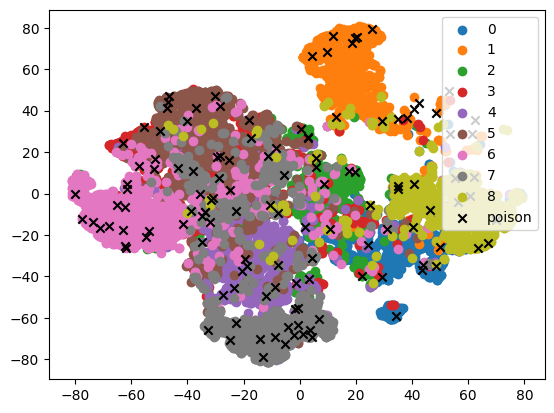

Epoch [211/300]	
	Step [0/391]	 Loss: 3.59002
	Step [50/391]	 Loss: 3.58819
	Step [100/391]	 Loss: 3.59165
	Step [150/391]	 Loss: 3.58603
	Step [200/391]	 Loss: 3.59631
	Step [250/391]	 Loss: 3.59241
	Step [300/391]	 Loss: 3.5943
	Step [350/391]	 Loss: 3.59604

	Training Loss: 3.5910088119604398
	Time Taken: 3.757679891586304 minutes
Epoch [212/300]	
	Step [0/391]	 Loss: 3.59024
	Step [50/391]	 Loss: 3.59628
	Step [100/391]	 Loss: 3.5921
	Step [150/391]	 Loss: 3.59641
	Step [200/391]	 Loss: 3.59034
	Step [250/391]	 Loss: 3.59508
	Step [300/391]	 Loss: 3.58738
	Step [350/391]	 Loss: 3.59358

	Training Loss: 3.5909323832568
	Time Taken: 3.7571381171544393 minutes
Epoch [213/300]	
	Step [0/391]	 Loss: 3.59295
	Step [50/391]	 Loss: 3.5982
	Step [100/391]	 Loss: 3.58989
	Step [150/391]	 Loss: 3.5931
	Step [200/391]	 Loss: 3.59301
	Step [250/391]	 Loss: 3.59061
	Step [300/391]	 Loss: 3.59851
	Step [350/391]	 Loss: 3.5982

	Training Loss: 3.590691315243616
	Time Taken: 3.7501548488934833 minu

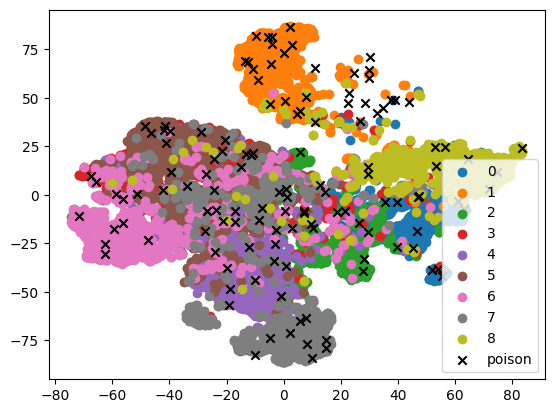

Epoch [221/300]	
	Step [0/391]	 Loss: 3.59322
	Step [50/391]	 Loss: 3.59223
	Step [100/391]	 Loss: 3.59206
	Step [150/391]	 Loss: 3.59215
	Step [200/391]	 Loss: 3.5948
	Step [250/391]	 Loss: 3.59036
	Step [300/391]	 Loss: 3.58982
	Step [350/391]	 Loss: 3.59288

	Training Loss: 3.590019234610945
	Time Taken: 3.763438045978546 minutes
Epoch [222/300]	
	Step [0/391]	 Loss: 3.59417
	Step [50/391]	 Loss: 3.59185
	Step [100/391]	 Loss: 3.58876
	Step [150/391]	 Loss: 3.59154
	Step [200/391]	 Loss: 3.59153
	Step [250/391]	 Loss: 3.58648
	Step [300/391]	 Loss: 3.58646
	Step [350/391]	 Loss: 3.59129

	Training Loss: 3.589791109494846
	Time Taken: 3.7530214905738832 minutes
Epoch [223/300]	
	Step [0/391]	 Loss: 3.58943
	Step [50/391]	 Loss: 3.59268
	Step [100/391]	 Loss: 3.58836
	Step [150/391]	 Loss: 3.59086
	Step [200/391]	 Loss: 3.5905
	Step [250/391]	 Loss: 3.59081
	Step [300/391]	 Loss: 3.58718
	Step [350/391]	 Loss: 3.59019

	Training Loss: 3.589550156117705
	Time Taken: 3.745554840564728 m

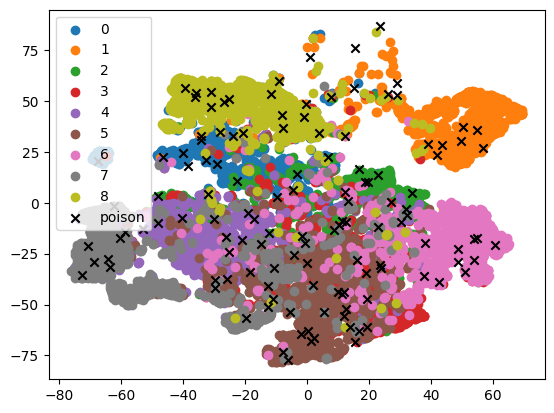

Epoch [231/300]	
	Step [0/391]	 Loss: 3.59406
	Step [50/391]	 Loss: 3.58661
	Step [100/391]	 Loss: 3.59475
	Step [150/391]	 Loss: 3.59385
	Step [200/391]	 Loss: 3.58793
	Step [250/391]	 Loss: 3.59314
	Step [300/391]	 Loss: 3.59182
	Step [350/391]	 Loss: 3.5876

	Training Loss: 3.588941649097921
	Time Taken: 3.761104695002238 minutes
Epoch [232/300]	
	Step [0/391]	 Loss: 3.59079
	Step [50/391]	 Loss: 3.58692
	Step [100/391]	 Loss: 3.59127
	Step [150/391]	 Loss: 3.59554
	Step [200/391]	 Loss: 3.5901
	Step [250/391]	 Loss: 3.59086
	Step [300/391]	 Loss: 3.58829
	Step [350/391]	 Loss: 3.59716

	Training Loss: 3.5891702870273834
	Time Taken: 3.7555214802424115 minutes
Epoch [233/300]	
	Step [0/391]	 Loss: 3.58856
	Step [50/391]	 Loss: 3.58536
	Step [100/391]	 Loss: 3.58995
	Step [150/391]	 Loss: 3.59289
	Step [200/391]	 Loss: 3.59006
	Step [250/391]	 Loss: 3.59165
	Step [300/391]	 Loss: 3.59103
	Step [350/391]	 Loss: 3.58597

	Training Loss: 3.5892527859534145
	Time Taken: 3.742147334416707

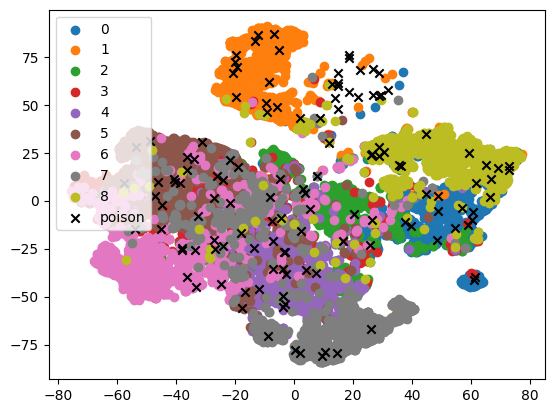

Epoch [241/300]	
	Step [0/391]	 Loss: 3.58777
	Step [50/391]	 Loss: 3.58898
	Step [100/391]	 Loss: 3.59056
	Step [150/391]	 Loss: 3.5898
	Step [200/391]	 Loss: 3.58962
	Step [250/391]	 Loss: 3.58996
	Step [300/391]	 Loss: 3.58857
	Step [350/391]	 Loss: 3.59157

	Training Loss: 3.5883937924719223
	Time Taken: 3.6820308407147726 minutes
Epoch [242/300]	
	Step [0/391]	 Loss: 3.58676
	Step [50/391]	 Loss: 3.58996
	Step [100/391]	 Loss: 3.58671
	Step [150/391]	 Loss: 3.59041
	Step [200/391]	 Loss: 3.58748
	Step [250/391]	 Loss: 3.58905
	Step [300/391]	 Loss: 3.58624
	Step [350/391]	 Loss: 3.5884

	Training Loss: 3.58843342483501
	Time Taken: 3.681772017478943 minutes
Epoch [243/300]	
	Step [0/391]	 Loss: 3.58939
	Step [50/391]	 Loss: 3.58681
	Step [100/391]	 Loss: 3.58965
	Step [150/391]	 Loss: 3.59037
	Step [200/391]	 Loss: 3.59327
	Step [250/391]	 Loss: 3.59751
	Step [300/391]	 Loss: 3.5895
	Step [350/391]	 Loss: 3.58779

	Training Loss: 3.5882772271285583
	Time Taken: 3.672564446926117 m

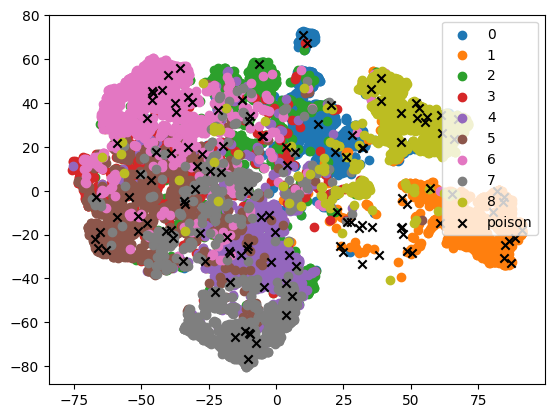

Epoch [251/300]	
	Step [0/391]	 Loss: 3.58742
	Step [50/391]	 Loss: 3.5829
	Step [100/391]	 Loss: 3.58596
	Step [150/391]	 Loss: 3.58774
	Step [200/391]	 Loss: 3.59002
	Step [250/391]	 Loss: 3.58659
	Step [300/391]	 Loss: 3.58539
	Step [350/391]	 Loss: 3.5912

	Training Loss: 3.587670603066759
	Time Taken: 3.6854227145512897 minutes
Epoch [252/300]	
	Step [0/391]	 Loss: 3.58844
	Step [50/391]	 Loss: 3.59202
	Step [100/391]	 Loss: 3.58518
	Step [150/391]	 Loss: 3.5879
	Step [200/391]	 Loss: 3.59258
	Step [250/391]	 Loss: 3.58926
	Step [300/391]	 Loss: 3.58643
	Step [350/391]	 Loss: 3.5864

	Training Loss: 3.5874940318524686
	Time Taken: 3.685731001694997 minutes
Epoch [253/300]	
	Step [0/391]	 Loss: 3.5888
	Step [50/391]	 Loss: 3.58802
	Step [100/391]	 Loss: 3.58517
	Step [150/391]	 Loss: 3.58639
	Step [200/391]	 Loss: 3.58685
	Step [250/391]	 Loss: 3.58448
	Step [300/391]	 Loss: 3.58898
	Step [350/391]	 Loss: 3.58673

	Training Loss: 3.5877337535019116
	Time Taken: 3.6756553808848063 m

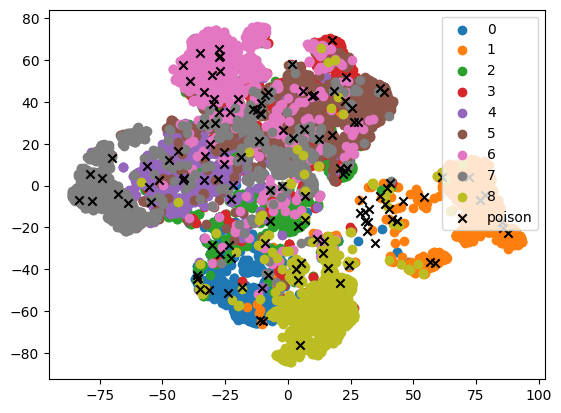

Epoch [261/300]	
	Step [0/391]	 Loss: 3.59096
	Step [50/391]	 Loss: 3.58847
	Step [100/391]	 Loss: 3.58842
	Step [150/391]	 Loss: 3.58738
	Step [200/391]	 Loss: 3.58771
	Step [250/391]	 Loss: 3.58412
	Step [300/391]	 Loss: 3.58454
	Step [350/391]	 Loss: 3.58557

	Training Loss: 3.5868286007200667
	Time Taken: 3.6803061723709107 minutes
Epoch [262/300]	
	Step [0/391]	 Loss: 3.5863
	Step [50/391]	 Loss: 3.58611
	Step [100/391]	 Loss: 3.58867
	Step [150/391]	 Loss: 3.58552
	Step [200/391]	 Loss: 3.58557
	Step [250/391]	 Loss: 3.58585
	Step [300/391]	 Loss: 3.589
	Step [350/391]	 Loss: 3.58772

	Training Loss: 3.586808851003037
	Time Taken: 3.676572807629903 minutes
Epoch [263/300]	
	Step [0/391]	 Loss: 3.58219
	Step [50/391]	 Loss: 3.58508
	Step [100/391]	 Loss: 3.59089
	Step [150/391]	 Loss: 3.58736
	Step [200/391]	 Loss: 3.59848
	Step [250/391]	 Loss: 3.58583
	Step [300/391]	 Loss: 3.59081
	Step [350/391]	 Loss: 3.59191

	Training Loss: 3.5868695776175965
	Time Taken: 3.6768228014310202

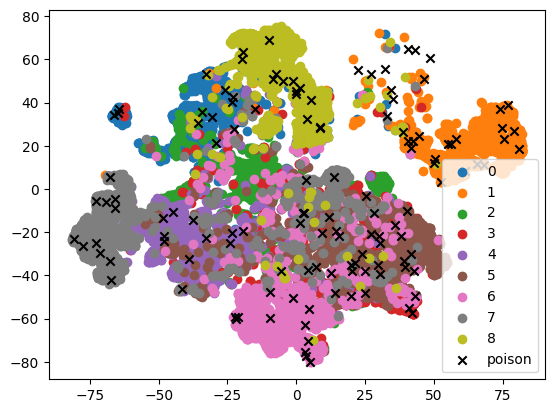

Epoch [271/300]	
	Step [0/391]	 Loss: 3.58678
	Step [50/391]	 Loss: 3.58714
	Step [100/391]	 Loss: 3.5877
	Step [150/391]	 Loss: 3.58603
	Step [200/391]	 Loss: 3.5888
	Step [250/391]	 Loss: 3.58702
	Step [300/391]	 Loss: 3.5866
	Step [350/391]	 Loss: 3.59017

	Training Loss: 3.5865607981181817
	Time Taken: 3.6829219659169516 minutes
Epoch [272/300]	
	Step [0/391]	 Loss: 3.58877
	Step [50/391]	 Loss: 3.58598
	Step [100/391]	 Loss: 3.58626
	Step [150/391]	 Loss: 3.58659
	Step [200/391]	 Loss: 3.58878
	Step [250/391]	 Loss: 3.58605
	Step [300/391]	 Loss: 3.58746
	Step [350/391]	 Loss: 3.58352

	Training Loss: 3.586290140591009
	Time Taken: 3.690521951516469 minutes
Epoch [273/300]	
	Step [0/391]	 Loss: 3.59118
	Step [50/391]	 Loss: 3.587
	Step [100/391]	 Loss: 3.58793
	Step [150/391]	 Loss: 3.58797
	Step [200/391]	 Loss: 3.58833
	Step [250/391]	 Loss: 3.58665
	Step [300/391]	 Loss: 3.58767
	Step [350/391]	 Loss: 3.58959

	Training Loss: 3.5862706646589975
	Time Taken: 3.6700233538945515 m

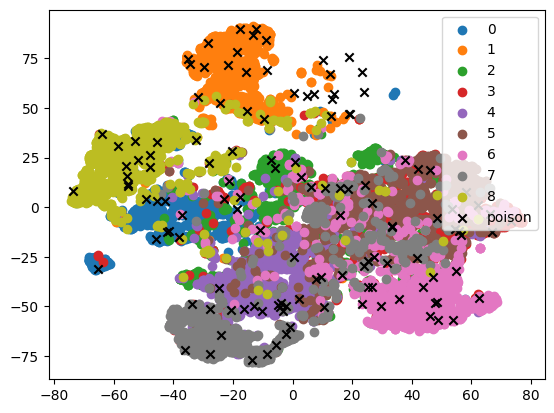

Epoch [281/300]	
	Step [0/391]	 Loss: 3.58534
	Step [50/391]	 Loss: 3.58883
	Step [100/391]	 Loss: 3.58876
	Step [150/391]	 Loss: 3.58727
	Step [200/391]	 Loss: 3.58556
	Step [250/391]	 Loss: 3.59011
	Step [300/391]	 Loss: 3.58622
	Step [350/391]	 Loss: 3.58813

	Training Loss: 3.5857750857272723
	Time Taken: 3.6853219827016193 minutes
Epoch [282/300]	
	Step [0/391]	 Loss: 3.58402
	Step [50/391]	 Loss: 3.58937
	Step [100/391]	 Loss: 3.58327
	Step [150/391]	 Loss: 3.58579
	Step [200/391]	 Loss: 3.58443
	Step [250/391]	 Loss: 3.58712
	Step [300/391]	 Loss: 3.58746
	Step [350/391]	 Loss: 3.58827

	Training Loss: 3.5858296024829834
	Time Taken: 3.6892386237780253 minutes
Epoch [283/300]	
	Step [0/391]	 Loss: 3.588
	Step [50/391]	 Loss: 3.59255
	Step [100/391]	 Loss: 3.58693
	Step [150/391]	 Loss: 3.58477
	Step [200/391]	 Loss: 3.57778
	Step [250/391]	 Loss: 3.58688
	Step [300/391]	 Loss: 3.58635
	Step [350/391]	 Loss: 3.58516

	Training Loss: 3.5856096488435556
	Time Taken: 3.6845553398132

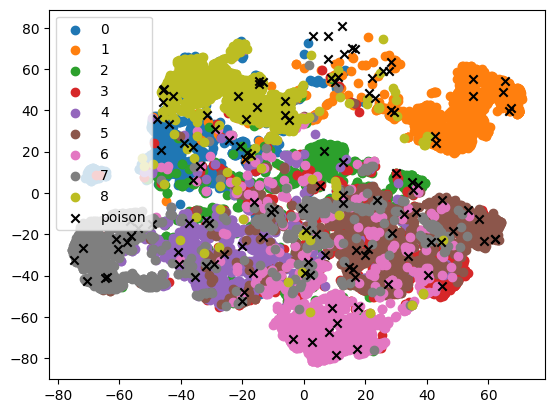

Epoch [291/300]	
	Step [0/391]	 Loss: 3.58718
	Step [50/391]	 Loss: 3.58379
	Step [100/391]	 Loss: 3.58175
	Step [150/391]	 Loss: 3.58522
	Step [200/391]	 Loss: 3.59109
	Step [250/391]	 Loss: 3.58951
	Step [300/391]	 Loss: 3.58613
	Step [350/391]	 Loss: 3.58617

	Training Loss: 3.5852739378009613
	Time Taken: 3.68016277551651 minutes
Epoch [292/300]	
	Step [0/391]	 Loss: 3.58405
	Step [50/391]	 Loss: 3.58597
	Step [100/391]	 Loss: 3.58936
	Step [150/391]	 Loss: 3.58281
	Step [200/391]	 Loss: 3.59241
	Step [250/391]	 Loss: 3.58315
	Step [300/391]	 Loss: 3.58297
	Step [350/391]	 Loss: 3.59284

	Training Loss: 3.5850587482647516
	Time Taken: 3.6778693715731303 minutes
Epoch [293/300]	
	Step [0/391]	 Loss: 3.58717
	Step [50/391]	 Loss: 3.58436
	Step [100/391]	 Loss: 3.58912
	Step [150/391]	 Loss: 3.58622
	Step [200/391]	 Loss: 3.58327
	Step [250/391]	 Loss: 3.58903
	Step [300/391]	 Loss: 3.58598
	Step [350/391]	 Loss: 3.58402

	Training Loss: 3.585261057709794
	Time Taken: 3.66031347513198

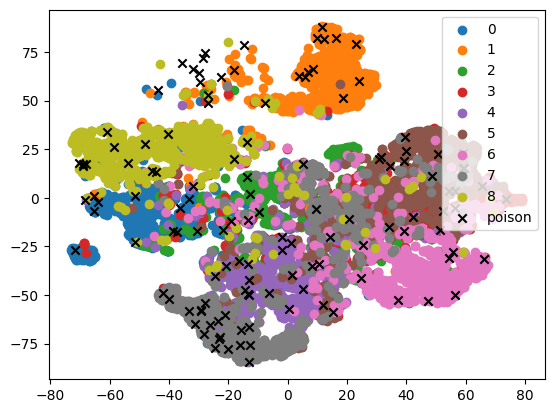

	Saved model, optimizer, scheduler and epoch info to ./saved_models/NEW-SimCLR.pt-300


In [28]:
losses = []

for epoch in range(start_epoch, epochs+1):
    print(f"Epoch [{epoch}/{epochs}]\t")
    stime = time.time()

    model.train()
    loss = train(dataloader, model, criterion, optimizer)
    losses.append(loss)

    if epoch <= 10:
        warmupscheduler.step()
    if epoch > 10:
        mainscheduler.step()
    
    print()
    print(f"\tTraining Loss: {loss}")
    time_taken = (time.time()-stime)/60
    print(f"\tTime Taken: {time_taken} minutes")

    if (epoch) % 10 == 0:
        save_model(model, optimizer, mainscheduler, epoch, f"NEW-SimCLR-{epoch}.pt")
        plot_features(model, dataloader_no_contrastive, 100)

## end training
save_model(model, optimizer, mainscheduler, epochs, f"NEW-SimCLR.pt-{epoch}")